### Visualizing Responses

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
X = np.load('drive/MyDrive/X_data.npy', mmap_mode='r')
y = np.load('drive/MyDrive/Y_data.npy', mmap_mode='r')



Mounted at /content/drive


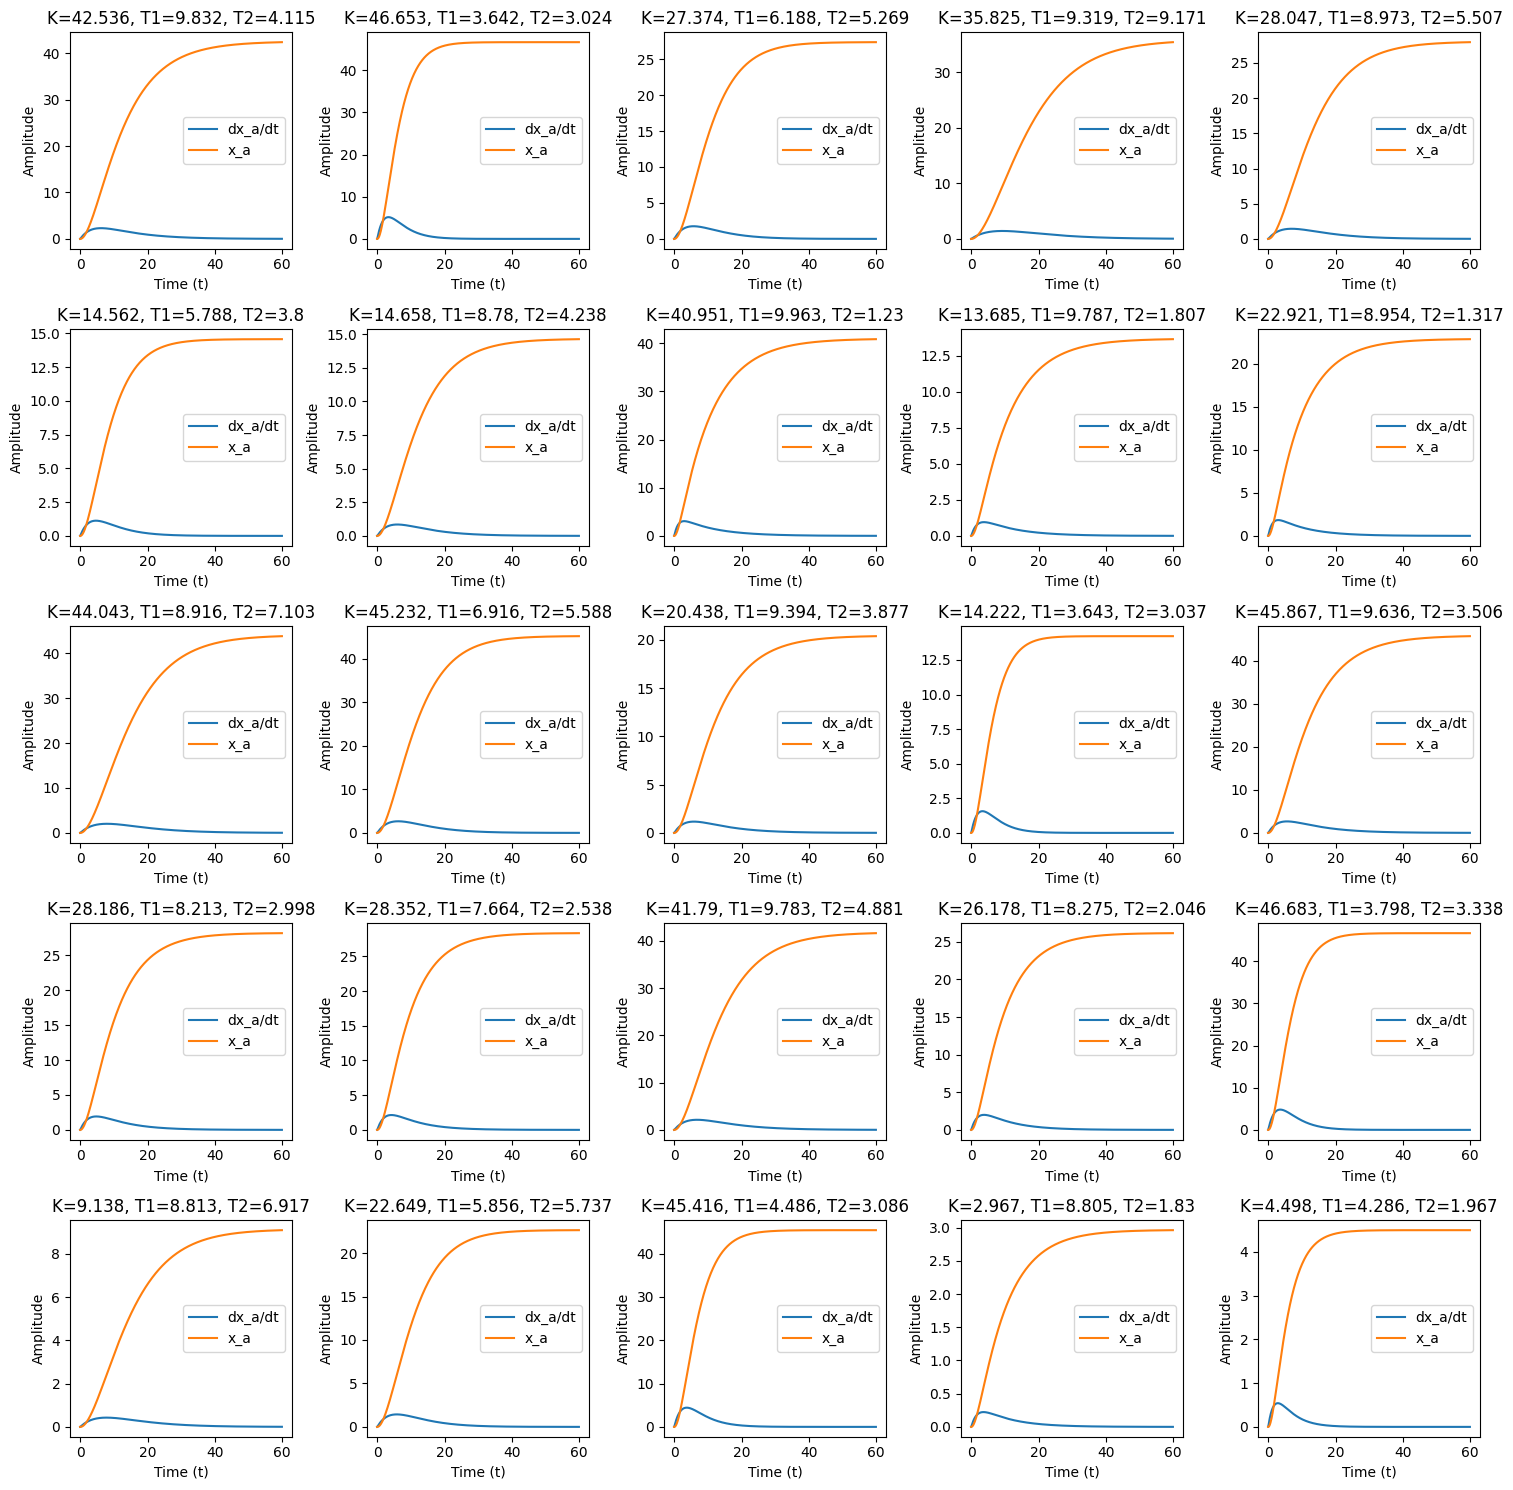

In [2]:
# ...existing code...
responses = X[0:25]
fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
    t = responses[i][:, 2]
    da_dt = responses[i][:, 0]
    x_a = responses[i][:, 1]
    K = y[i][0]
    T1 = y[i][1]
    T2 = y[i][2]
    ax.plot(t, da_dt, label='dx_a/dt')
    ax.plot(t, x_a, label='x_a')
    ax.set_title(f'K={K}, T1={T1}, T2={T2}')
    ax.legend()
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Amplitude')

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show() # Display the figure

### Parameters

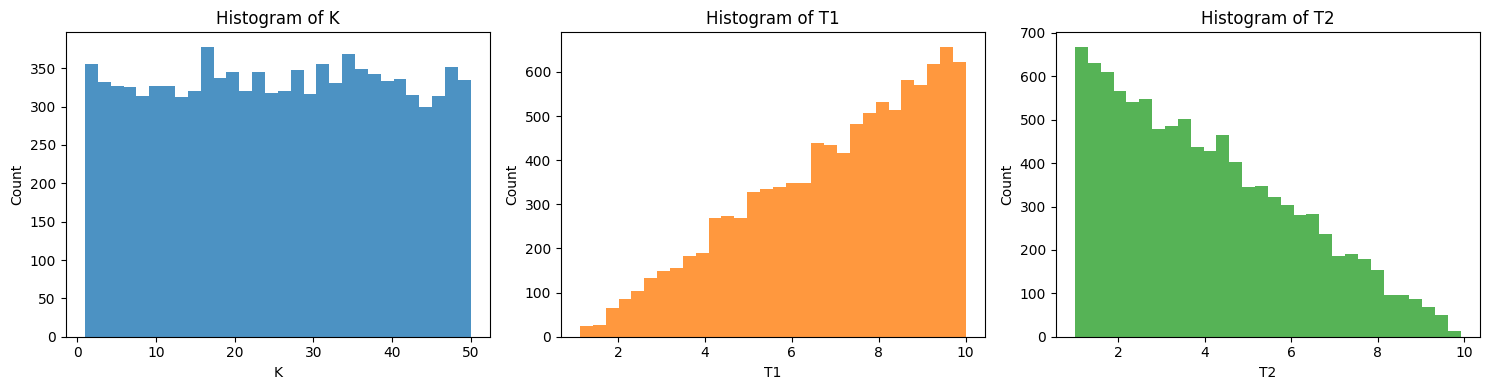

In [35]:
import numpy as np
import matplotlib.pyplot as plt

y = np.asarray(y, dtype=float)  # ensure numeric array, shape (N,3)

labels = ['K', 'T1', 'T2']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, ax in enumerate(axes):
    ax.hist(y[:, i], bins=30, color=f'C{i}', alpha=0.8)
    ax.set_title(f'Histogram of {labels[i]}')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### Distributions

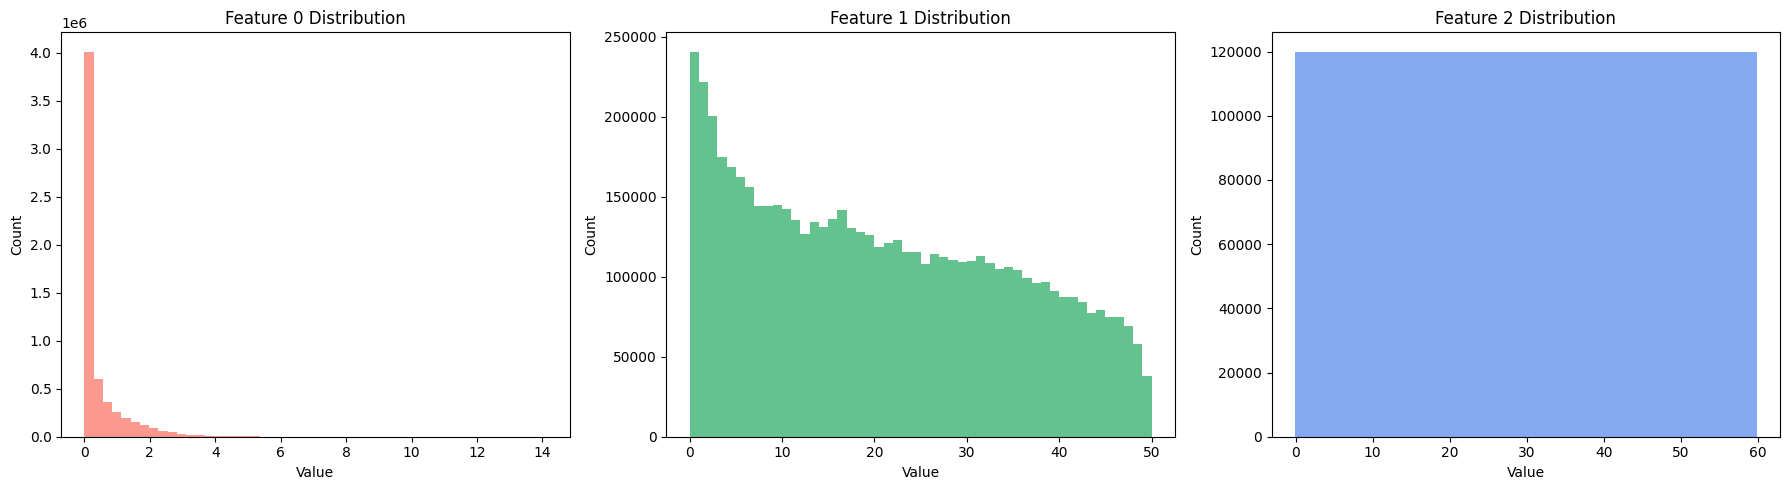

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['salmon', 'mediumseagreen', 'cornflowerblue']
labels = ['Feature 0', 'Feature 1', 'Feature 2']

for i in range(0,3):
  feat = X[:,:,i].flatten()
  # print(feat) # Commenting out print to avoid large output
  axes[i].hist(feat, bins=50, color=colors[i], alpha=0.8)
  axes[i].set_title(f'{labels[i]} Distribution')
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### TRAINING MODEL

1.   List item
2.   List item



In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Input, Concatenate
from tensorflow.keras.optimizers import Adam

random_state = 42
tf.keras.utils.set_random_seed(random_state)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if len(physical_devices) > 0:
    print(f"Device Name: {physical_devices[0].name}")
else:
    print("⚠️ No GPU found. Training will run on CPU.")


Num GPUs Available:  1
Device Name: /physical_device:GPU:0


### Preprocessing

In [33]:
#X_xa = X[:, : , 1:3] # Corrected: Ensure X_xa remains 3D (samples, timesteps, 2 for features 1 and 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Reshape X_train and X_test for StandardScaler
# StandardScaler expects a 2D array: (n_samples, n_features)
# Here, each 'sample' will be a single time step from all experiments, so we flatten the first two dimensions.
num_samples_train, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)

num_samples_test, _, _ = X_test.shape
X_test_reshaped = X_test.reshape(-1, num_features)

# Initialize and fit StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reshaped) # Fit on training data only

# Transform both training and testing data
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to original 3D shape (num_samples, time_steps, num_features) for Conv1D
X_train_scaled = X_train_scaled_reshaped.reshape(num_samples_train, time_steps, num_features)
X_test_scaled = X_test_scaled_reshaped.reshape(num_samples_test, time_steps, num_features)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(f"Original X shape: {X.shape}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Original X shape: (10000, 600, 3)
X_train_scaled shape: (8000, 600, 3)
X_test_scaled shape: (2000, 600, 3)
y_train shape: (8000, 3)
y_test shape: (2000, 3)


### CNN with branching

In [43]:
inputs = Input(shape=(600, 3))
# --- Start Branching ---
# Branch 1: Fast (Microscope)
branch_a = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)

# Branch 2: Medium (Standard)
branch_b = Conv1D(filters=32, kernel_size=15, padding='same', activation='relu')(inputs)

# Branch 3: Slow (Telescope)
branch_c = Conv1D(filters=32, kernel_size=60, padding='same', activation='relu')(inputs)

# Combine branches
concatenated = Concatenate()([branch_a, branch_b, branch_c])
# --- End Branching ---

# 2. Continue the chain (The "Sequential" part, but written Functionally)
# Instead of model.add(Layer), we do: x = Layer()(previous_x)

x = MaxPooling1D(pool_size=2)(concatenated)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# 3. Output Layer
# Dense(3) matches your request for 3 regression targets
outputs = Dense(3, activation='linear')(x)

# 4. Finalize the Model
model = Model(inputs=inputs, outputs=outputs)

# 5. Compile
optimizer_lr_adjusted = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_lr_adjusted, loss='mse')

# 6. Check your architecture
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 600, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 600, 32)   │        320 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 600, 32)   │      1,472 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 600, 32)   │      5,792 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 600, 96)   │          0 │ conv1d_14[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_15[0][0],  │
│                     │                   │            │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 300, 96)   │          0 │ concatenate_3[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 28800)     │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │  3,686,528 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     16,512 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 3)         │        387 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,711,011 (14.16 MB)

 Trainable params: 3,711,011 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.4802 - val_loss: 0.1296
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0856 - val_loss: 0.0777
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0628 - val_loss: 0.0723
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0544 - val_loss: 0.0498
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0484 - val_loss: 0.0376
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0414 - val_loss: 0.0311
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0380 - val_loss: 0.0336
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0372 - val_loss: 0.0291
Epoch 9/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0318 - val_loss: 0.0281
Epoch 10/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0305
Epoch 11/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0312 - val_loss: 0.0507
Epoch 12/200
200/200 ━━━━━━━━━━━━━━━━━━━━

In [45]:
#loss, mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"Test Loss: {loss:.4f}")
#print(f"Test MAE: {mae:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0053
Test Loss: 0.0055


In [46]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test_scaled)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [47]:
import pandas as pd

results_df = pd.DataFrame({
    'K_DIFF' : y_actual[:, 0] - y_pred[:, 0],
    'T1_DIFF' : y_actual[:, 1] - y_pred[:, 1],
    'T2_DIFF' : y_actual[:, 2] - y_pred[:, 2],
    'Actual_K': y_actual[:, 0],
    'Actual_T1': y_actual[:, 1],
    'Actual_T2': y_actual[:, 2],

})

display(results_df)

,K_DIFF,T1_DIFF,T2_DIFF,Actual_K,Actual_T1,Actual_T2
0,1.082430,-0.114470,0.007005,9.021,7.004,1.282
1,0.155073,0.012004,-0.384635,49.615,9.462,5.415
2,0.209904,-0.002119,-0.060376,27.698,8.661,2.793
3,0.817364,-0.002392,-0.051713,47.980,5.198,4.366
4,0.562153,0.055135,-0.022727,17.958,6.495,3.584
...,...,...,...,...,...,...
1995,0.933593,0.078268,-0.042896,15.688,2.922,1.314
1996,0.764509,0.007275,0.070097,16.228,4.036,1.014
1997,0.197762,-0.040256,-0.049842,4.309,3.729,2.356
1998,0.480544,-0.027290,-0.035914,19.912,9.532,4.654


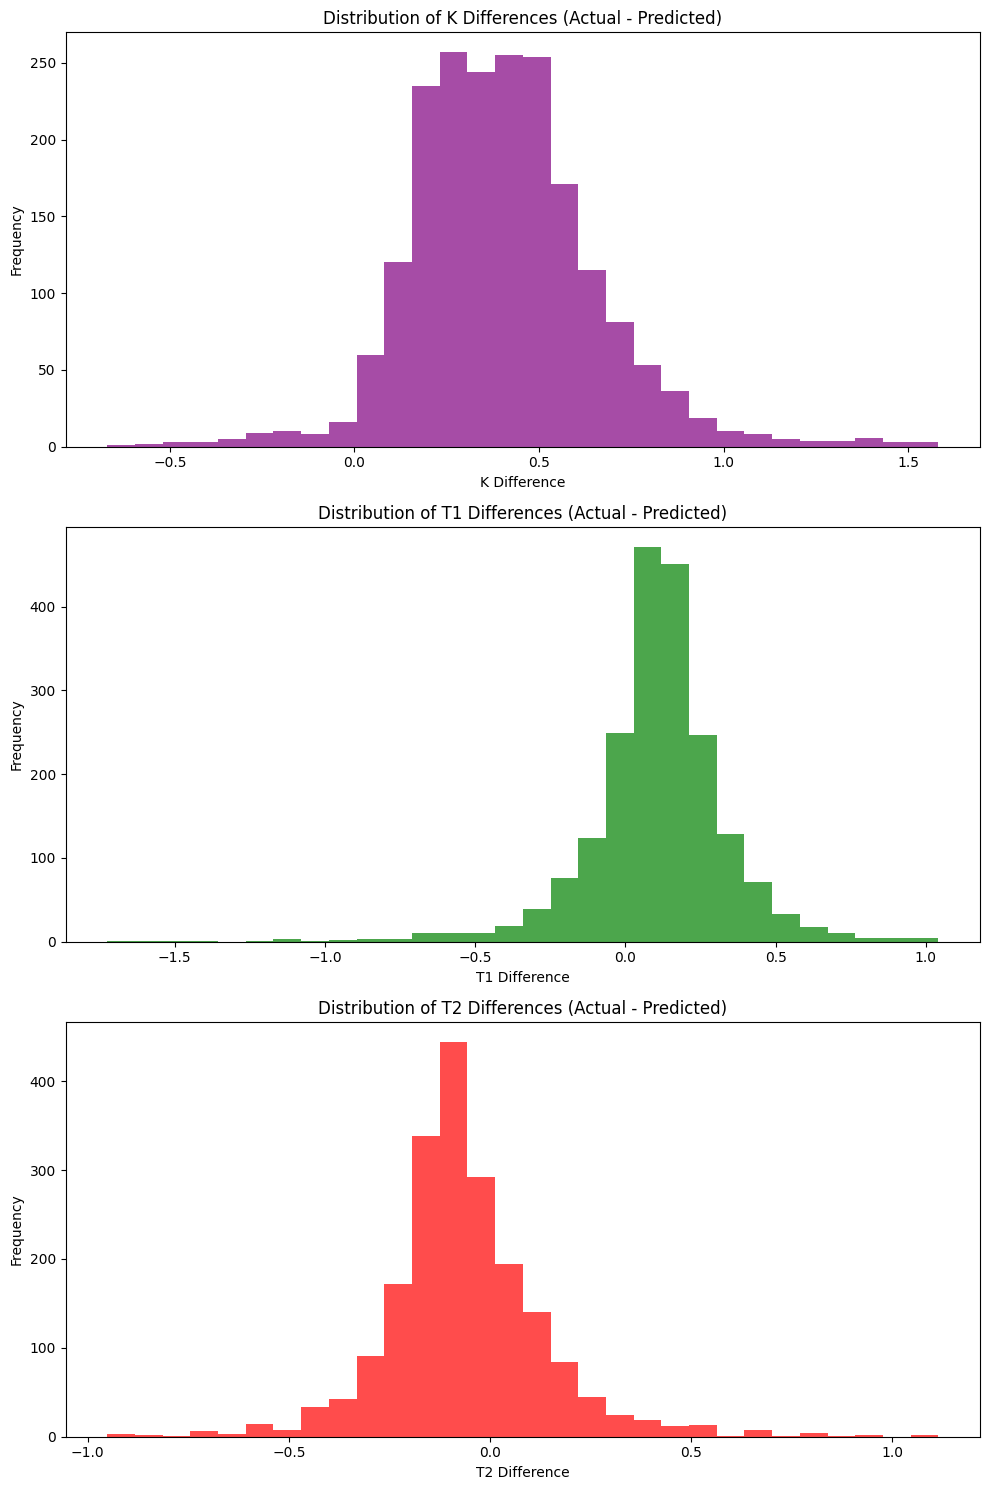

In [42]:
import matplotlib.pyplot as plt

fig_diff, axes_diff = plt.subplots(3, 1, figsize=(10, 15))

# K_DIFF distribution
axes_diff[0].hist(results_df['K_DIFF'], bins=30, color='purple', alpha=0.7)
axes_diff[0].set_title('Distribution of K Differences (Actual - Predicted)')
axes_diff[0].set_xlabel('K Difference')
axes_diff[0].set_ylabel('Frequency')

# T1_DIFF distribution
axes_diff[1].hist(results_df['T1_DIFF'], bins=30, color='green', alpha=0.7)
axes_diff[1].set_title('Distribution of T1 Differences (Actual - Predicted)')
axes_diff[1].set_xlabel('T1 Difference')
axes_diff[1].set_ylabel('Frequency')

# T2_DIFF distribution
axes_diff[2].hist(results_df['T2_DIFF'], bins=30, color='red', alpha=0.7)
axes_diff[2].set_title('Distribution of T2 Differences (Actual - Predicted)')
axes_diff[2].set_xlabel('T2 Difference')
axes_diff[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()